In [1]:
# https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [2]:
import pandas as pd

df = pd.read_csv(path + "/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Dataset shape: (50000, 2)

--- RAW REVIEWS ---

Review 1 (sentiment=positive):

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to ...

Review 2 (sentiment=positive):

A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the referen ...

Review 3 (sentiment=positive):

I thought this was a wonderful way to spend 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



=== Training RNN-32 ===
Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.5025 - loss: 0.7019 - val_accuracy: 0.5051 - val_loss: 0.6948
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5753 - loss: 0.6680 - val_accuracy: 0.5090 - val_loss: 0.7036
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6406 - loss: 0.5566 - val_accuracy: 0.5084 - val_loss: 0.7804
RNN-32 Test Accuracy: 0.5001 | Training Time: 35.00 sec

=== Training RNN-64-32 ===
Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.5025 - loss: 0.7361 - val_accuracy: 0.4988 - val_loss: 0.6937
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.5048 - loss: 0.7065 - val_accuracy: 0.5195 - val_loss: 0.6922
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.4998 - loss: 0.6989 - val_accuracy: 0.5067 - val_loss: 0.6927
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.5065 - loss: 0.6951 - val_accuracy: 0.5182 - val_l

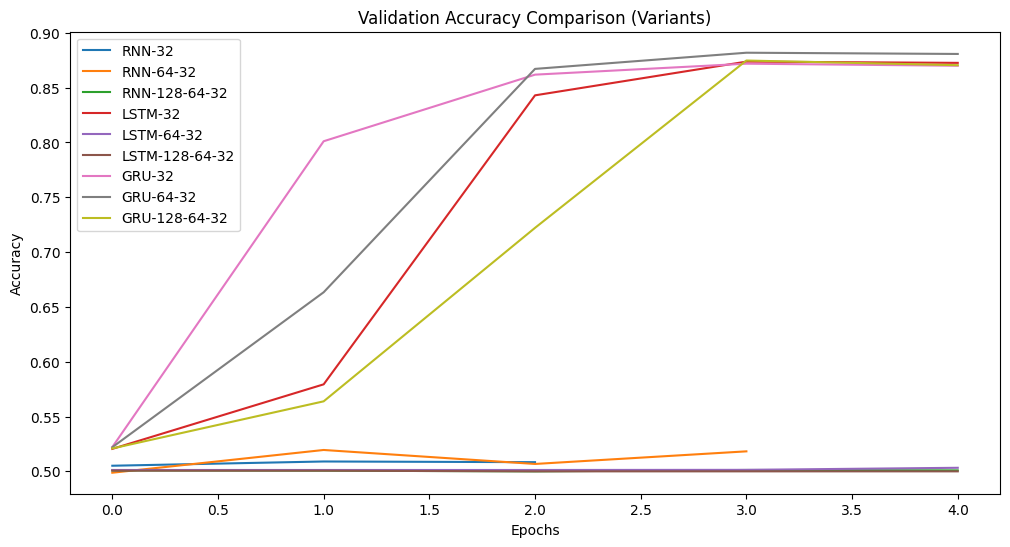

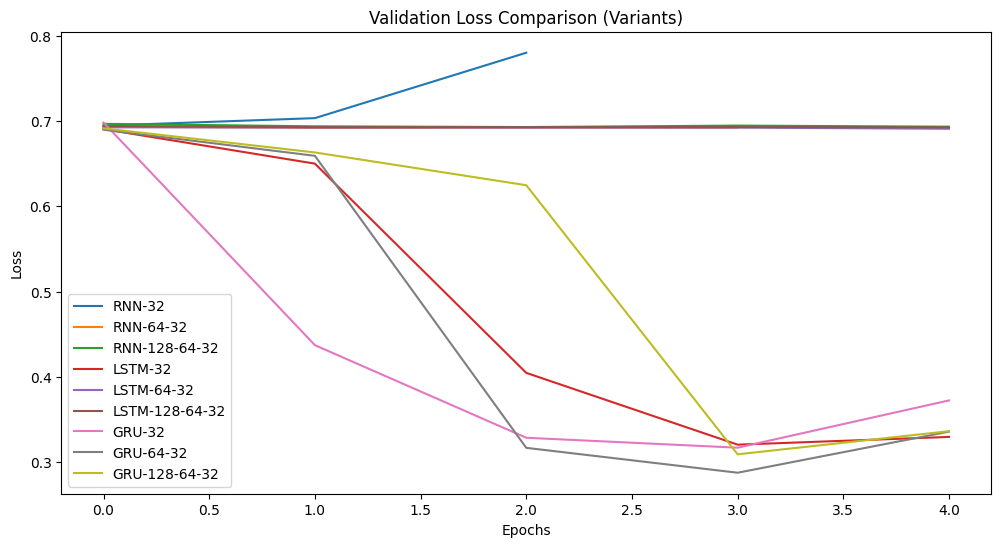

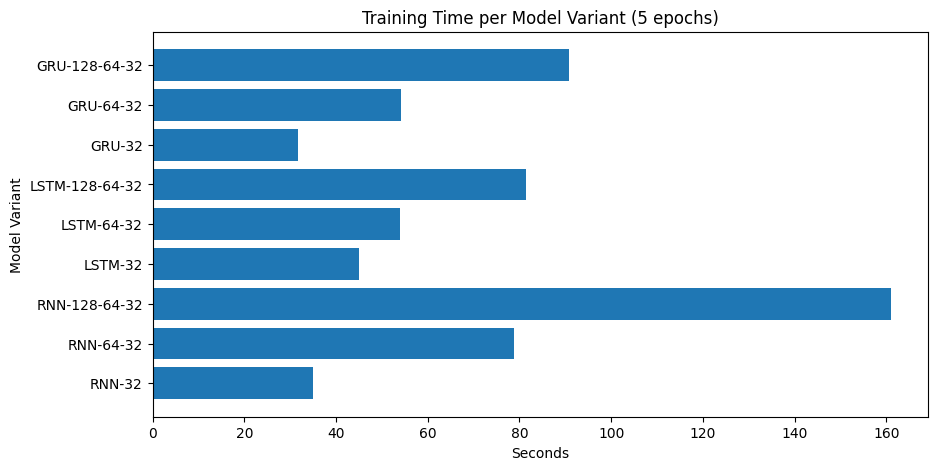


=== Summary Table ===
            Model  Accuracy  Training Time (sec)
0          RNN-32    0.5001            34.998244
1       RNN-64-32    0.5093            78.817040
2   RNN-128-64-32    0.5039           160.915802
3         LSTM-32    0.8739            45.097842
4      LSTM-64-32    0.5065            53.849229
5  LSTM-128-64-32    0.4961            81.358981
6          GRU-32    0.8751            31.695154
7       GRU-64-32    0.8802            54.216601
8   GRU-128-64-32    0.8761            90.702495


In [3]:
# ========================================
# Sentiment Analysis with RNN, LSTM, GRU
# With Vocabulary + Sequence Length Tuning
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------
# Step 1: Load Dataset
# -------------------------
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
print("Dataset shape:", df.shape)

print("\n--- RAW REVIEWS ---")
for i in range(3):
    print(f"\nReview {i+1} (sentiment={df['sentiment'][i]}):\n")
    print(df['review'][i][:400], "...")

# -------------------------
# Step 2: Cleaning
# -------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)  # remove HTML
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)     # remove numbers
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_review"] = df["review"].apply(clean_text)
df["label"] = df["sentiment"].map({"positive": 1, "negative": 0})

print("\n--- CLEANED REVIEWS ---")
for i in range(3):
    print(f"\nOriginal:\n{df['review'][i][:200]}...\n")
    print(f"Cleaned:\n{df['clean_review'][i][:200]}...\n")

# -------------------------
# Step 3: Fine-tune Vocab & Maxlen
# -------------------------
# Students can try:
# vocab_size = 5000, 10000, 20000
# maxlen = 100, 200, 300

vocab_size = 15000   # 🔧 change here
maxlen = 250         # 🔧 change here

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_review"])

X = tokenizer.texts_to_sequences(df["clean_review"])
X = pad_sequences(X, maxlen=maxlen, padding="post", truncating="post")
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining shape: {X_train.shape}, Testing shape: {X_test.shape}")
print(f"Vocab size used: {vocab_size}, Max sequence length: {maxlen}")

# -------------------------
# Step 4: Model Builders
# -------------------------
embedding_dim = 128
early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

def build_rnn(units_list=[64], dropout=0.3):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    for i, units in enumerate(units_list):
        model.add(SimpleRNN(units, return_sequences=(i < len(units_list)-1)))
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_lstm(units_list=[64], dropout=0.3):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    for i, units in enumerate(units_list):
        model.add(LSTM(units, return_sequences=(i < len(units_list)-1)))
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_gru(units_list=[64], dropout=0.3):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    for i, units in enumerate(units_list):
        model.add(GRU(units, return_sequences=(i < len(units_list)-1)))
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# -------------------------
# Step 5: Variants
# -------------------------
configs = [
    # RNN Variants
    ("RNN-32", build_rnn([32], 0.2)),
    ("RNN-64-32", build_rnn([64, 32], 0.3)),
    ("RNN-128-64-32", build_rnn([128, 64, 32], 0.5)),

    # LSTM Variants
    ("LSTM-32", build_lstm([32], 0.2)),
    ("LSTM-64-32", build_lstm([64, 32], 0.3)),
    ("LSTM-128-64-32", build_lstm([128, 64, 32], 0.5)),

    # GRU Variants
    ("GRU-32", build_gru([32], 0.2)),
    ("GRU-64-32", build_gru([64, 32], 0.3)),
    ("GRU-128-64-32", build_gru([128, 64, 32], 0.5)),
]

# -------------------------
# Step 6: Train & Evaluate
# -------------------------
history = {}
results = {}
timings = {}

for name, model in configs:
    print(f"\n=== Training {name} ===")
    start = time.time()
    h = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=5,
        batch_size=64,
        callbacks=[early_stop],
        verbose=1
    )
    end = time.time()
    elapsed = end - start

    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{name} Test Accuracy: {acc:.4f} | Training Time: {elapsed:.2f} sec")

    history[name] = h
    results[name] = acc
    timings[name] = elapsed

# -------------------------
# Step 7: Plots
# -------------------------
# Accuracy Plot
plt.figure(figsize=(12,6))
for name, h in history.items():
    plt.plot(h.history["val_accuracy"], label=name)
plt.title("Validation Accuracy Comparison (Variants)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss Plot
plt.figure(figsize=(12,6))
for name, h in history.items():
    plt.plot(h.history["val_loss"], label=name)
plt.title("Validation Loss Comparison (Variants)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Runtime Bar Plot
plt.figure(figsize=(10,5))
plt.barh(list(timings.keys()), list(timings.values()))
plt.title("Training Time per Model Variant (5 epochs)")
plt.xlabel("Seconds")
plt.ylabel("Model Variant")
plt.show()

# Summary Table
summary_df = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": list(results.values()),
    "Training Time (sec)": list(timings.values())
})
print("\n=== Summary Table ===")
print(summary_df)
